In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from keras.callbacks import Callback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.layers import Layer, GRU, Bidirectional, Dense, Input, Reshape, GlobalAveragePooling1D
import nltk
from nltk.corpus import wordnet
import random
from lime.lime_text import LimeTextExplainer

nltk.download('punkt')

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv(r"F:\Aspect Based Sentiment Analysis\Resturant\Restaurant - Sheet1.csv")
df.head()

,SL,Text,Category,Polarity
0,0,"স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।",service,negative
1,1,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",food,positive
2,2,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",anecdotes/miscellaneous,negative
3,3,"খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...",food,positive
4,4,যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...,service,positive


In [3]:
df = df[['Text', 'Category', 'Polarity']]
df.head()

,Text,Category,Polarity
0,"স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।",service,negative
1,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",food,positive
2,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",anecdotes/miscellaneous,negative
3,"খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...",food,positive
4,যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...,service,positive


In [4]:
df['Category'].value_counts()

Category
food                       710
anecdotes/miscellaneous    610
service                    333
ambience                   231
price                      175
Name: count, dtype: int64

In [5]:
df['Polarity'].value_counts()

Polarity
positive    1221
negative     472
neutral      251
conflict     115
Name: count, dtype: int64

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize Bengali stopwords and lemmatizer
stop_words = set(stopwords.words('bengali'))
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
df.head()

,Text,Category,Polarity
0,স্টাফ ভয়ঙ্কর,service,negative
1,শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...,food,positive
2,শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...,anecdotes/miscellaneous,negative
3,খাবার একদমই ব্যতিক্রমী সক্ষম রান্নাঘর গর্বের খ...,food,positive
4,গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা আপনাকে খেতে...,service,positive


In [7]:
from sklearn.utils import resample

# Define a function to perform random upsampling
def upsample(df, target_column):
    # Get the maximum count of samples in any class
    max_count = df[target_column].value_counts().max()

    # Separate each class and upsample the minority classes
    upsampled_dfs = []
    for label in df[target_column].unique():
        # Get samples for the current label
        df_label = df[df[target_column] == label]

        # Upsample minority classes to match the majority class count
        df_upsampled = resample(
            df_label,
            replace=True,            # Sample with replacement
            n_samples=max_count,     # Match the number of samples in the majority class
            random_state=42          # Set random seed for reproducibility
        )
        upsampled_dfs.append(df_upsampled)

    # Combine the upsampled DataFrames
    return pd.concat(upsampled_dfs)

# Apply upsampling to 'Category' and 'Polarity'
df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

# Shuffle the DataFrame to mix the resampled classes
df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("Category distribution after upsampling:")
print(df_upsampled['Category'].value_counts())
print("\nPolarity distribution after upsampling:")
print(df_upsampled['Polarity'].value_counts())


Category distribution after upsampling:
Category
anecdotes/miscellaneous    2091
ambience                   1929
service                    1506
price                      1394
food                       1308
Name: count, dtype: int64

Polarity distribution after upsampling:
Polarity
positive    2057
neutral     2057
conflict    2057
negative    2057
Name: count, dtype: int64


In [8]:
df_upsampled.head()

,Text,Category,Polarity
0,রাজ্জাক উইকেট নিতেই মন্তব্য আলোচনা সমালোচনা বছ...,bowling,negative
1,সাকিব বুন মা রাস্তা ঘাটে ডিস্ট্রাব,other,neutral
2,চেয়ে রানে জিতার রেকড,batting,neutral
3,সাব্বিরমোসাদ্দেকসানজামুলরাব্বিশুভাসিষ টেস্ট দল...,team,neutral
4,ক্রিকেট টীমকে ধরনের নাটক গ্রহণযোগ্য,batting,neutral


In [ ]:
from sklearn.preprocessing import LabelEncoder

category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

In [27]:
# Tokenize the text using DistilBERT with padding and truncation
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='np')

df_upsampled['tokens'] = df_upsampled['Text'].apply(lambda x: tokenize_function(x))

# Train-test split
train_df, test_df = train_test_split(df_upsampled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [29]:
# Convert to TensorFlow Dataset
def create_tensor_dataset(df):
    # Tokenize input text and convert to TensorFlow tensors
    inputs = tokenizer(list(df['Text']), padding='max_length', truncation=True, max_length=128, return_tensors='tf')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Convert labels to tensors
    labels_category = tf.convert_to_tensor(df['Category_encoded'].values)
    labels_polarity = tf.convert_to_tensor(df['Polarity_encoded'].values)

    return tf.data.Dataset.from_tensor_slices(((input_ids, attention_mask), (labels_category, labels_polarity)))


In [30]:
# Load pre-trained DistilBERT for sequence classification
from transformers import TFDistilBertForSequenceClassification

# Load the DistilBERT model for classification tasks
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [31]:
# Define the model inputs
input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32)
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32)

# The model already provides output for classification tasks
distilbert_output = model(input_ids, attention_mask=attention_mask).logits

# Multi-task model
category_output = tf.keras.layers.Dense(5, activation='softmax', name='category_output')(distilbert_output)
polarity_output = tf.keras.layers.Dense(3, activation='softmax', name='polarity_output')(distilbert_output)

multi_task_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[category_output, polarity_output])

# Compile the model
multi_task_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                         loss={'category_output': 'sparse_categorical_crossentropy', 'polarity_output': 'sparse_categorical_crossentropy'},
                         metrics=['accuracy'])

multi_task_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955010   ['input_17[0][0]',               
 assification_4 (TFDistilBertFo  rOutput(loss=None,               'input_18[0][0]']               
 rSequenceClassification)       logits=(None, 2),                                                 
                                 hidden_states=None                                         

In [32]:
# Create train and validation datasets
train_dataset = create_tensor_dataset(train_df)
val_dataset = create_tensor_dataset(val_df)

In [33]:
history = multi_task_model.fit(train_dataset.batch(16), epochs=20, validation_data=val_dataset.batch(16))

Epoch 1/20
473/473 [==============================] - 90s 175ms/step - loss: 2.5297 - category_output_loss: 1.4814 - polarity_output_loss: 1.0483 - category_output_accuracy: 0.3074 - polarity_output_accuracy: 0.4344 - val_loss: 2.2730 - val_category_output_loss: 1.2971 - val_polarity_output_loss: 0.9759 - val_category_output_accuracy: 0.4238 - val_polarity_output_accuracy: 0.4893
Epoch 2/20
473/473 [==============================] - 81s 172ms/step - loss: 2.1482 - category_output_loss: 1.2132 - polarity_output_loss: 0.9350 - category_output_accuracy: 0.4718 - polarity_output_accuracy: 0.5504 - val_loss: 1.9554 - val_category_output_loss: 1.1461 - val_polarity_output_loss: 0.8092 - val_category_output_accuracy: 0.4857 - val_polarity_output_accuracy: 0.6464
Epoch 3/20
473/473 [==============================] - 81s 172ms/step - loss: 1.8819 - category_output_loss: 1.0637 - polarity_output_loss: 0.8182 - category_output_accuracy: 0.5067 - polarity_output_accuracy: 0.6319 - val_loss: 1.7926

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [35]:
# Step 1: Make predictions on the test set
# Prepare the test dataset
test_dataset = create_tensor_dataset(test_df)

# Get predictions from the model
predictions = multi_task_model.predict(test_dataset.batch(16))

# Step 2: Convert predictions to class labels
category_pred = np.argmax(predictions[0], axis=1)  # Category predictions (argmax for softmax output)
polarity_pred = np.argmax(predictions[1], axis=1)  # Polarity predictions

# Step 3: Convert true labels to numpy arrays
category_true = test_df['Category_encoded'].values
polarity_true = test_df['Polarity_encoded'].values

# Step 4: Calculate classification report for category and polarity
category_report = classification_report(category_true, category_pred, target_names=category_encoder.classes_)
polarity_report = classification_report(polarity_true, polarity_pred, target_names=polarity_encoder.classes_)

# Print the classification reports
print("Category Classification Report:\n", category_report)
print("Polarity Classification Report:\n", polarity_report)

132/132 [==============================] - 9s 55ms/step
Category Classification Report:
                  precision    recall  f1-score   support

        batting       0.83      0.86      0.84       458
        bowling       0.68      0.93      0.79       583
          other       0.79      0.80      0.79       343
           team       0.69      0.26      0.38       406
team management       0.84      0.87      0.86       310

       accuracy                           0.76      2100
      macro avg       0.77      0.75      0.73      2100
   weighted avg       0.76      0.76      0.73      2100

Polarity Classification Report:
               precision    recall  f1-score   support

    negative       0.58      0.65      0.61       718
     neutral       0.60      0.53      0.56       689
    positive       0.96      0.93      0.95       693

    accuracy                           0.71      2100
   macro avg       0.71      0.71      0.71      2100
weighted avg       0.71      0.71   

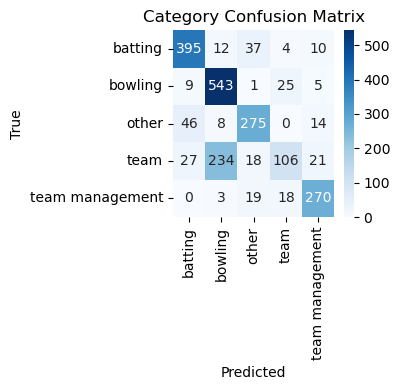

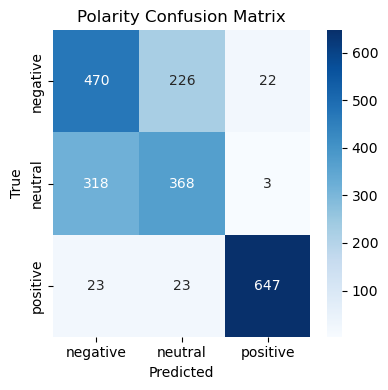

In [36]:
# Step 5: Generate confusion matrices
category_cm = confusion_matrix(category_true, category_pred)
polarity_cm = confusion_matrix(polarity_true, polarity_pred)

# Category Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(category_cm, annot=True, fmt="d", cmap="Blues", xticklabels=category_encoder.classes_, yticklabels=category_encoder.classes_)
plt.title('Category Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Polarity Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(polarity_cm, annot=True, fmt="d", cmap="Blues", xticklabels=polarity_encoder.classes_, yticklabels=polarity_encoder.classes_)
plt.title('Polarity Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

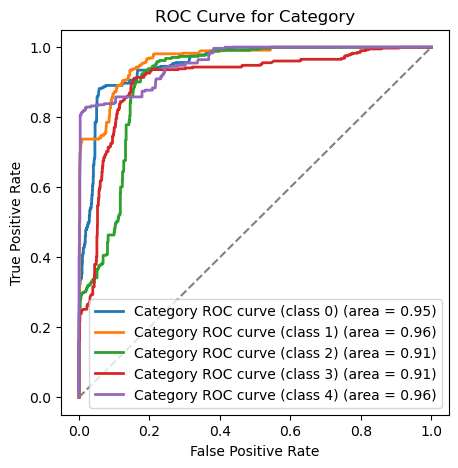

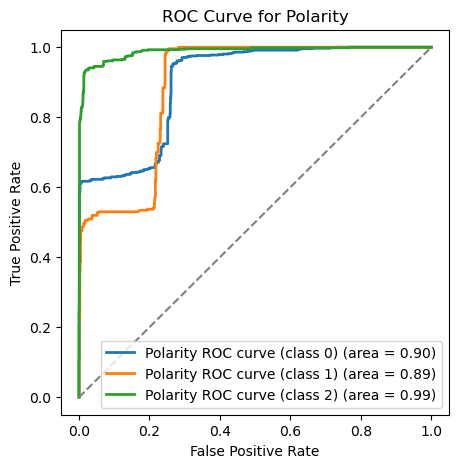

In [40]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# Step 6: ROC Curve and AUC Calculation for Multi-Class
# Binarize the labels for multi-class ROC
category_true_binarized = label_binarize(category_true, classes=np.arange(len(category_encoder.classes_)))
polarity_true_binarized = label_binarize(polarity_true, classes=np.arange(len(polarity_encoder.classes_)))

# Compute ROC curve and AUC for each class
fpr_category = {}
tpr_category = {}
roc_auc_category = {}
fpr_polarity = {}
tpr_polarity = {}
roc_auc_polarity = {}

# For category
for i in range(category_true_binarized.shape[1]):
    fpr_category[i], tpr_category[i], _ = roc_curve(category_true_binarized[:, i], category_probs[:, i])
    roc_auc_category[i] = auc(fpr_category[i], tpr_category[i])

# For polarity
for i in range(polarity_true_binarized.shape[1]):
    fpr_polarity[i], tpr_polarity[i], _ = roc_curve(polarity_true_binarized[:, i], polarity_probs[:, i])
    roc_auc_polarity[i] = auc(fpr_polarity[i], tpr_polarity[i])

# Plot ROC curves for Category
plt.figure(figsize=(5, 5))
for i in range(len(category_encoder.classes_)):
    plt.plot(fpr_category[i], tpr_category[i], lw=2, label='Category ROC curve (class %d) (area = %0.2f)' % (i, roc_auc_category[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Category')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for Polarity
plt.figure(figsize=(5, 5))
for i in range(len(polarity_encoder.classes_)):
    plt.plot(fpr_polarity[i], tpr_polarity[i], lw=2, label='Polarity ROC curve (class %d) (area = %0.2f)' % (i, roc_auc_polarity[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Polarity')
plt.legend(loc="lower right")
plt.show()


In [41]:
# Step 7: Macro Precision, Recall, F1-Score Calculation
from sklearn.metrics import precision_score, recall_score, f1_score

# Macro precision, recall, and F1-score for category
macro_precision_category = precision_score(category_true, category_pred, average='macro')
macro_recall_category = recall_score(category_true, category_pred, average='macro')
macro_f1_category = f1_score(category_true, category_pred, average='macro')

# Macro precision, recall, and F1-score for polarity
macro_precision_polarity = precision_score(polarity_true, polarity_pred, average='macro')
macro_recall_polarity = recall_score(polarity_true, polarity_pred, average='macro')
macro_f1_polarity = f1_score(polarity_true, polarity_pred, average='macro')

# Print macro scores
print(f"Macro Precision (Category): {macro_precision_category:.4f}")
print(f"Macro Recall (Category): {macro_recall_category:.4f}")
print(f"Macro F1-Score (Category): {macro_f1_category:.4f}")
print(f"Macro Precision (Polarity): {macro_precision_polarity:.4f}")
print(f"Macro Recall (Polarity): {macro_recall_polarity:.4f}")
print(f"Macro F1-Score (Polarity): {macro_f1_polarity:.4f}")

Macro Precision (Category): 0.7658
Macro Recall (Category): 0.7455
Macro F1-Score (Category): 0.7320
Macro Precision (Polarity): 0.7129
Macro Recall (Polarity): 0.7074
Macro F1-Score (Polarity): 0.7088


In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Lambda
import nltk
nltk.download('averaged_perceptron_tagger')

# Step 1: Initialize DistilBERT for embedding
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSe

In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Lambda, GlobalAveragePooling1D, Flatten
from tensorflow.keras import Model
from transformers import DistilBertTokenizer, TFDistilBertModel

# Initialize tokenizer and BERT model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize inputs
def tokenize_inputs(texts, max_length=128):
    inputs = tokenizer(
        texts, return_tensors="tf", padding="max_length",
        truncation=True, max_length=max_length
    )
    return inputs['input_ids'], inputs['attention_mask']

# Dynamic Adjacency Matrix Creation
def create_dynamic_adjacency_matrix(bert_embeddings):
    # Compute the dot product between all pairs of embeddings (similarity)
    dot_product = tf.matmul(bert_embeddings, bert_embeddings, transpose_b=True)
    
    # Normalize embeddings (L2 norm)
    norm = tf.norm(bert_embeddings, axis=-1, keepdims=True)
    
    # Avoid division by zero by adding a small epsilon value
    adjacency_matrix = dot_product / (tf.matmul(norm, norm, transpose_b=True) + 1e-6)

    return adjacency_matrix

# Define GRU Fusion Layer
class GRUFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(GRUFusionLayer, self).__init__(**kwargs)
        self.gru = GRU(units, return_sequences=True)

    def call(self, x):
        return self.gru(x)

class DenseGNNLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(DenseGNNLayer, self).__init__(**kwargs)
        self.units = units
        self.dense = Dense(units)

    def call(self, features, adj_matrix):
        # Perform a simple matrix multiplication between features and adjacency matrix
        h = tf.matmul(adj_matrix, features)  # Message passing
        return self.dense(h)  # Apply transformation to the message passing result

# Hierarchical GNN with Task-Specific Heads and Pooling
class HierarchicalGNN(tf.keras.layers.Layer):
    def __init__(self, units, task_output_size, **kwargs):
        super(HierarchicalGNN, self).__init__(**kwargs)
        self.shared_gnn = DenseGNNLayer(units)
        self.task_specific_gnn = DenseGNNLayer(units)
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()  # Pooling layer to collapse sequence dimension
        self.task_output = Dense(task_output_size, activation='softmax')

    def call(self, features, adj_matrix):
        shared_features = self.shared_gnn(features, adj_matrix)
        task_specific_features = self.task_specific_gnn(shared_features, adj_matrix)
        
        # Apply GlobalAveragePooling1D to collapse sequence length
        pooled_features = self.pooling(task_specific_features)  # Shape will be (batch_size, units)
        
        return self.task_output(pooled_features)

from tensorflow.keras.layers import GlobalAveragePooling1D

class MultiTaskGNNModel(Model):
    def __init__(self, gnn_units, category_output_size, polarity_output_size, **kwargs):
        super(MultiTaskGNNModel, self).__init__(**kwargs)
        self.distilbert = bert_model
        self.gru_fusion = GRUFusionLayer(gnn_units)

        self.category_gnn = DenseGNNLayer(gnn_units)
        self.polarity_gnn = DenseGNNLayer(gnn_units)

        # Add pooling layers to reduce the sequence dimension
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Add separate task-specific Dense layers for the final outputs
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

        # Projection layer to reduce the BERT embedding dimensionality
        self.feature_adjustment_layer = Dense(gnn_units, activation='relu')

    def call(self, input_ids, attention_mask):
        # Pass through DistilBERT to get embeddings
        bert_output = self.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Project BERT embeddings to match the GNN units dimension
        adjusted_features = self.feature_adjustment_layer(bert_output)

        # Create dynamic adjacency matrix
        adj_matrix = create_dynamic_adjacency_matrix(adjusted_features)

        # GRU Fusion for Contextualized Embeddings
        fused_features = self.gru_fusion(adjusted_features)
        
        # Multi-Task GNN Heads
        category_features = self.category_gnn(fused_features, adj_matrix)
        polarity_features = self.polarity_gnn(fused_features, adj_matrix)

        # Pool the GNN outputs to collapse the sequence dimension
        category_features_pooled = self.category_pooling(category_features)
        polarity_features_pooled = self.polarity_pooling(polarity_features)

        # Apply task-specific output layers for final predictions
        category_output = self.category_output_layer(category_features_pooled)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)

        return category_output, polarity_output

# Input layer specifications (128 tokens for BERT input)
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Initialize the multi-task model
gnn_units = 64  # Number of units in GNN layers
category_output_size = 5  # Number of classes for Category task
polarity_output_size = 3  # Number of classes for Polarity task

# Initialize the multi-task model with output sizes
multi_task_gnn_model = MultiTaskGNNModel(
    gnn_units=gnn_units, 
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size
)

# Model architecture
output_category, output_polarity = multi_task_gnn_model(input_ids, attention_mask)

# Build the model by compiling
model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    metrics=['accuracy']
)

# Model summary
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_gnn_model_31 (Multi  ((None, 5),         66445896    ['input_ids[0][0]',              
 TaskGNNModel)                   (None, 3))                       'attention_mask[0][0]']         
                                                                                                  
Total params: 66,445,896
Trainable params: 66,445,896
Non-trainable params: 0
_____________

In [91]:
history = model.fit(train_dataset.batch(16), epochs=3, validation_data=val_dataset.batch(16))

Epoch 1/3


473/473 [==============================] - 105s 203ms/step - loss: 3.2651 - multi_task_gnn_model_31_loss: 1.9591 - multi_task_gnn_model_31_1_loss: 1.3060 - multi_task_gnn_model_31_accuracy: 0.3218 - multi_task_gnn_model_31_1_accuracy: 0.4385 - val_loss: 2.3666 - val_multi_task_gnn_model_31_loss: 1.3641 - val_multi_task_gnn_model_31_1_loss: 1.0026 - val_multi_task_gnn_model_31_accuracy: 0.4524 - val_multi_task_gnn_model_31_1_accuracy: 0.5095
Epoch 2/3
473/473 [==============================] - 88s 186ms/step - loss: 2.2832 - multi_task_gnn_model_31_loss: 1.3315 - multi_task_gnn_model_31_1_loss: 0.9517 - multi_task_gnn_model_31_accuracy: 0.4554 - multi_task_gnn_model_31_1_accuracy: 0.5286 - val_loss: 1.9502 - val_multi_task_gnn_model_31_loss: 1.0924 - val_multi_task_gnn_model_31_1_loss: 0.8577 - val_multi_task_gnn_model_31_accuracy: 0.5690 - val_multi_task_gnn_model_31_1_accuracy: 0.6119
Epoch 3/3
473/473 [==============================] - 88s 186ms/step - loss: 1.8607 - multi_task_gnn_m

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [95]:
# Define your class labels
category_class_names = ["Class1", "Class2", "Class3", "Class4", "Class5"]
polarity_class_names = ["Positive", "Negative", "Neutral"]

# 1. Evaluate model accuracy on the test dataset
evaluation_results = model.evaluate(test_dataset.batch(16))
# The evaluation_results will contain a list with all returned metrics

# Print out the results
print(f"Total Loss: {evaluation_results[0]}")
print(f"Category Task Loss: {evaluation_results[1]}")
print(f"Polarity Task Loss: {evaluation_results[2]}")
print(f"Category Test Accuracy: {evaluation_results[3]}")
print(f"Polarity Test Accuracy: {evaluation_results[4]}")

132/132 [==============================] - 11s 80ms/step - loss: 1.4259 - multi_task_gnn_model_31_loss: 0.8566 - multi_task_gnn_model_31_1_loss: 0.5693 - multi_task_gnn_model_31_accuracy: 0.6952 - multi_task_gnn_model_31_1_accuracy: 0.7614
Total Loss: 1.4258700609207153
Category Task Loss: 0.8566108345985413
Polarity Task Loss: 0.569259524345398
Category Test Accuracy: 0.6952381134033203
Polarity Test Accuracy: 0.7614285945892334


1/1 [==============================] - 0s 45ms/step
Category Classification Report:
              precision    recall  f1-score   support

      Class1       0.82      0.60      0.69       458
      Class2       0.75      0.85      0.80       583
      Class3       0.78      0.46      0.58       343
      Class4       0.57      0.70      0.63       406
      Class5       0.61      0.79      0.69       310

    accuracy                           0.70      2100
   macro avg       0.71      0.68      0.68      2100
weighted avg       0.72      0.70      0.69      2100

Polarity Classification Report:
              precision    recall  f1-score   support

    Positive       0.72      0.74      0.73       718
    Negative       0.78      0.78      0.78       689
     Neutral       0.79      0.76      0.77       693

    accuracy                           0.76      2100
   macro avg       0.76      0.76      0.76      2100
weighted avg       0.76      0.76      0.76      2100



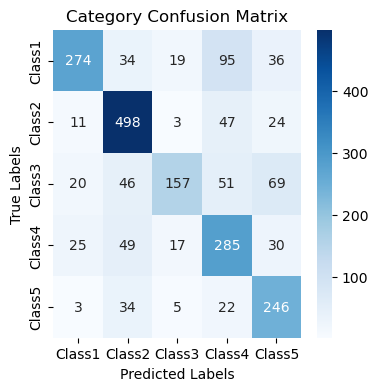

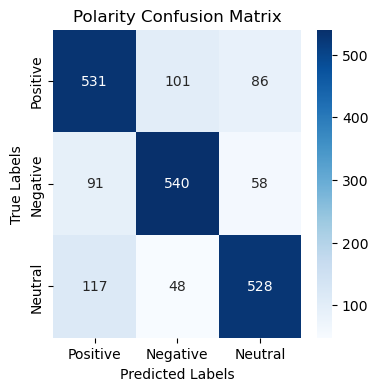

132/132 [==============================] - 10s 62ms/step


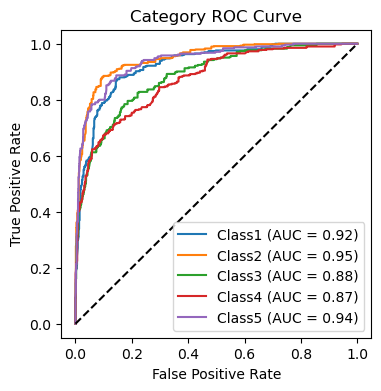

132/132 [==============================] - 8s 62ms/step


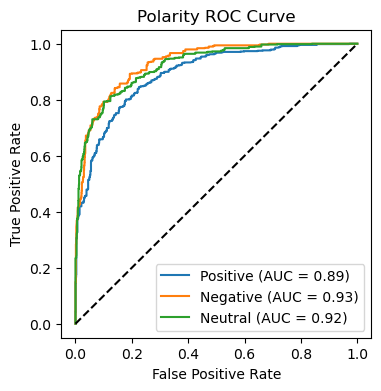

In [98]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get true labels and predictions for category and polarity tasks
true_category_labels = []
true_polarity_labels = []
pred_category_labels = []
pred_polarity_labels = []

for batch in test_dataset.batch(16):
    inputs, labels = batch
    input_ids, attention_mask = inputs  # Unpack the inputs tuple
    category_labels, polarity_labels = labels  # Unpack the labels tuple
    
    # Collect true labels
    true_category_labels.extend(category_labels.numpy())
    true_polarity_labels.extend(polarity_labels.numpy())
    
    # Get model predictions
    category_preds, polarity_preds = model.predict([input_ids, attention_mask])
    pred_category_labels.extend(np.argmax(category_preds, axis=1))
    pred_polarity_labels.extend(np.argmax(polarity_preds, axis=1))


# Convert true labels and predictions to numpy arrays
true_category_labels = np.array(true_category_labels)
true_polarity_labels = np.array(true_polarity_labels)
pred_category_labels = np.array(pred_category_labels)
pred_polarity_labels = np.array(pred_polarity_labels)

# 2. Classification Report
print("Category Classification Report:")
print(classification_report(true_category_labels, pred_category_labels, target_names=category_class_names))

print("Polarity Classification Report:")
print(classification_report(true_polarity_labels, pred_polarity_labels, target_names=polarity_class_names))

# 3. Confusion Matrix
def plot_confusion_matrix(true_labels, pred_labels, class_names, title):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Plot confusion matrices for category and polarity tasks
plot_confusion_matrix(true_category_labels, pred_category_labels, category_class_names, "Category Confusion Matrix")
plot_confusion_matrix(true_polarity_labels, pred_polarity_labels, polarity_class_names, "Polarity Confusion Matrix")

# 4. ROC Curve (One-vs-Rest for multi-class)
def plot_roc_curve(true_labels, pred_probs, class_names, title):
    plt.figure(figsize=(4, 4))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random predictions
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

# Category ROC Curve
category_pred_probs = model.predict(test_dataset.batch(16))[0]  # Probability predictions for category task
plot_roc_curve(true_category_labels, category_pred_probs, category_class_names, "Category ROC Curve")

# Polarity ROC Curve
polarity_pred_probs = model.predict(test_dataset.batch(16))[1]  # Probability predictions for polarity task
plot_roc_curve(true_polarity_labels, polarity_pred_probs, polarity_class_names, "Polarity ROC Curve")


In [116]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Lambda, GlobalAveragePooling1D, Flatten
from tensorflow.keras import Model
from transformers import DistilBertTokenizer, TFDistilBertModel

# Initialize tokenizer and BERT model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize inputs
def tokenize_inputs(texts, max_length=128):
    inputs = tokenizer(
        texts, return_tensors="tf", padding="max_length",
        truncation=True, max_length=max_length
    )
    return inputs['input_ids'], inputs['attention_mask']

# Multi-Head Attention Layer
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim
        )

    def call(self, query, key, value):
        return self.attention(query, key, value)

# Define GRU Fusion Layer
class GRUFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(GRUFusionLayer, self).__init__(**kwargs)
        self.gru = GRU(units, return_sequences=True)

    def call(self, x):
        return self.gru(x)

class DenseGNNLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(DenseGNNLayer, self).__init__(**kwargs)
        self.units = units
        self.dense = Dense(units)  # To adjust the feature dimension
        self.adj_dense = Dense(units)  # To adjust adjacency matrix dimension

    def call(self, features, adj_matrix):
        # Ensure the adjacency matrix has the correct dimensions to perform the multiplication
        adj_matrix_transformed = self.adj_dense(adj_matrix)  # Apply Dense layer to adj_matrix

        # The features tensor needs to be reshaped to perform matrix multiplication with adj_matrix
        features_transformed = self.dense(features)  # Apply Dense layer to features

        # Perform matrix multiplication between adjusted features and adjacency matrix
        h = tf.matmul(features_transformed, adj_matrix_transformed, transpose_b=True)  # Message passing

        return h  # Output the transformed features after multiplication


# Hierarchical GNN with Task-Specific Heads and Pooling
class HierarchicalGNN(tf.keras.layers.Layer):
    def __init__(self, units, task_output_size, **kwargs):
        super(HierarchicalGNN, self).__init__(**kwargs)
        self.shared_gnn = DenseGNNLayer(units)
        self.task_specific_gnn = DenseGNNLayer(units)
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()  # Pooling layer to collapse sequence dimension
        self.task_output = Dense(task_output_size, activation='softmax')

    def call(self, features, adj_matrix):
        shared_features = self.shared_gnn(features, adj_matrix)
        task_specific_features = self.task_specific_gnn(shared_features, adj_matrix)
        
        # Do not apply pooling here yet
        return task_specific_features  # Return the sequence of features, not pooled


class MultiTaskGNNModel(Model):
    def __init__(self, gnn_units, category_output_size, polarity_output_size, num_heads, **kwargs):
        super(MultiTaskGNNModel, self).__init__(**kwargs)
        self.distilbert = bert_model
        self.gru_fusion = GRUFusionLayer(gnn_units)

        # Define Multi-Head Attention Layer once in the initialization
        self.multi_head_attention = MultiHeadAttentionLayer(num_heads=num_heads, key_dim=64)

        # Add pooling layers to reduce the sequence dimension
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Add separate task-specific Dense layers for the final outputs
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

        # Projection layer to reduce the BERT embedding dimensionality to match the attention mechanism
        self.feature_adjustment_layer = Dense(128, activation='relu')

        # Define the Dense layer once here for the projection
        self.dense_projection_layer = Dense(64, activation='relu')  # Use this for projection in the adjacency matrix creation

        # Define the Hierarchical GNN layers for both tasks
        self.category_gnn = HierarchicalGNN(units=gnn_units, task_output_size=category_output_size)
        self.polarity_gnn = HierarchicalGNN(units=gnn_units, task_output_size=polarity_output_size)

        # Assign num_heads as an instance variable so it can be accessed in the call method
        self.num_heads = num_heads

    def call(self, input_ids, attention_mask):
        # Pass through DistilBERT to get embeddings
        bert_output = self.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Project BERT embeddings to match the GNN units dimension
        adjusted_features = self.feature_adjustment_layer(bert_output)

        # Ensure the projection matches embedding_dim (adjust the number of features to match)
        # Create dynamic adjacency matrix using multi-head attention
        adj_matrix = create_dynamic_adjacency_matrix_with_attention(adjusted_features, self.multi_head_attention, self.dense_projection_layer, num_heads=self.num_heads)

        # GRU Fusion for Contextualized Embeddings
        fused_features = self.gru_fusion(adjusted_features)
        
        # Multi-Task GNN Heads
        category_features = self.category_gnn(fused_features, adj_matrix)
        polarity_features = self.polarity_gnn(fused_features, adj_matrix)

        # Apply GlobalAveragePooling1D to collapse the sequence dimension
        category_features_pooled = self.category_pooling(category_features)
        polarity_features_pooled = self.polarity_pooling(polarity_features)

        # Apply task-specific output layers for final predictions
        category_output = self.category_output_layer(category_features_pooled)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)

        return category_output, polarity_output


# Update create_dynamic_adjacency_matrix_with_attention to accept the pre-created MultiHeadAttention layer
def create_dynamic_adjacency_matrix_with_attention(bert_embeddings, multi_head_attention, projection_layer, num_heads=4, key_dim=64):
    # Apply the pre-created Dense layer (projection layer) to BERT embeddings
    projected_embeddings = projection_layer(bert_embeddings)

    # Use the pre-created MultiHeadAttention layer for the attention mechanism
    attention_output = multi_head_attention(query=projected_embeddings, key=projected_embeddings, value=projected_embeddings)
    
    # Normalize attention output (L2 norm) across the feature dimension (axis=-1)
    norm = tf.norm(attention_output, axis=-1, keepdims=True)
    
    # Normalize the attention output by dividing by its norm
    adjacency_matrix = attention_output / (norm + 1e-6)  # Avoid division by zero
    
    return adjacency_matrix


# Input layer specifications (128 tokens for BERT input)
num_heads = 4  # Number of attention heads
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Initialize the multi-task model
gnn_units = 64  # Number of units in GNN layers
category_output_size = 5  # Number of classes for Category task
polarity_output_size = 3  # Number of classes for Polarity task

# Initialize the multi-task model with output sizes
multi_task_gnn_model = MultiTaskGNNModel(
    gnn_units=gnn_units,
    num_heads = num_heads,
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size
)

# Model architecture
output_category, output_polarity = multi_task_gnn_model(input_ids, attention_mask)

# Build the model by compiling
model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    metrics=['accuracy']
)

# Model summary
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_gnn_model_44 (Multi  ((None, 5),         66615688    ['input_ids[0][0]',              
 TaskGNNModel)                   (None, 3))                       'attention_mask[0][0]']         
                                                                                                  
Total params: 66,615,688
Trainable params: 66,615,688
Non-trainable params: 0
_____________

In [117]:
history = model.fit(train_dataset.batch(16), epochs=3, validation_data=val_dataset.batch(16))

Epoch 1/3


473/473 [==============================] - 114s 222ms/step - loss: 2.5178 - multi_task_gnn_model_44_loss: 1.4990 - multi_task_gnn_model_44_1_loss: 1.0188 - multi_task_gnn_model_44_accuracy: 0.3161 - multi_task_gnn_model_44_1_accuracy: 0.4390 - val_loss: 2.1571 - val_multi_task_gnn_model_44_loss: 1.3115 - val_multi_task_gnn_model_44_1_loss: 0.8455 - val_multi_task_gnn_model_44_accuracy: 0.4179 - val_multi_task_gnn_model_44_1_accuracy: 0.5643
Epoch 2/3
473/473 [==============================] - 90s 190ms/step - loss: 2.0393 - multi_task_gnn_model_44_loss: 1.2871 - multi_task_gnn_model_44_1_loss: 0.7522 - multi_task_gnn_model_44_accuracy: 0.4119 - multi_task_gnn_model_44_1_accuracy: 0.5972 - val_loss: 1.7120 - val_multi_task_gnn_model_44_loss: 1.1225 - val_multi_task_gnn_model_44_1_loss: 0.5895 - val_multi_task_gnn_model_44_accuracy: 0.4631 - val_multi_task_gnn_model_44_1_accuracy: 0.6464
Epoch 3/3
473/473 [==============================] - 90s 190ms/step - loss: 1.7143 - multi_task_gnn_m

In [124]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, GlobalAveragePooling1D
from tensorflow.keras import Model
from transformers import DistilBertTokenizer, TFDistilBertModel

# Initialize tokenizer and BERT model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize inputs
def tokenize_inputs(texts, max_length=128):
    inputs = tokenizer(
        texts, return_tensors="tf", padding="max_length",
        truncation=True, max_length=max_length
    )
    return inputs['input_ids'], inputs['attention_mask']

# GCN Layer
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation='relu', **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.dense = Dense(units, use_bias=False)

    def call(self, features, adj_matrix):
        # Normalize the adjacency matrix
        adj_matrix = self.normalize_adjacency_matrix(adj_matrix)

        # Perform graph convolution: H' = A*X*W
        h = tf.matmul(adj_matrix, features)  # A*X
        h = self.dense(h)  # Apply weight matrix W

        # Apply the activation function
        if self.activation:
            h = tf.keras.activations.get(self.activation)(h)

        return h

    def normalize_adjacency_matrix(self, adj_matrix):
        """ Normalize adjacency matrix by adding self-loops and applying symmetric normalization """
        # Add self-loops (identity matrix)
        batch_size = tf.shape(adj_matrix)[0]
        num_tokens = tf.shape(adj_matrix)[1]
    
        adj_matrix = adj_matrix + tf.eye(num_tokens, batch_shape=[batch_size], dtype=adj_matrix.dtype)
    
        # Symmetric normalization: D^(-1/2) * A * D^(-1/2)
        degree_matrix = tf.reduce_sum(adj_matrix, axis=-1)
        degree_matrix_inv_sqrt = tf.pow(degree_matrix + 1e-6, -0.5)
        degree_matrix_inv_sqrt = tf.linalg.diag(degree_matrix_inv_sqrt)
    
        adj_matrix_normalized = tf.matmul(degree_matrix_inv_sqrt, adj_matrix)
        adj_matrix_normalized = tf.matmul(adj_matrix_normalized, degree_matrix_inv_sqrt)
    
        return adj_matrix_normalized
     
# Define GRU Fusion Layer
class GRUFusionLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(GRUFusionLayer, self).__init__(**kwargs)
        self.gru = GRU(units, return_sequences=True)

    def call(self, x):
        return self.gru(x)

# Hierarchical GNN with Task-Specific Heads
class HierarchicalGNN(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(HierarchicalGNN, self).__init__(**kwargs)
        self.shared_gcn = GCNLayer(units)
        self.task_specific_gcn = GCNLayer(units)
        self.pooling = GlobalAveragePooling1D()

    def call(self, features, adj_matrix):
        shared_features = self.shared_gcn(features, adj_matrix)
        task_specific_features = self.task_specific_gcn(shared_features, adj_matrix)
        return task_specific_features

# MultiTask GNN Model with BERT
class MultiTaskGNNModel(Model):
    def __init__(self, gnn_units, category_output_size, polarity_output_size, num_heads, **kwargs):
        super(MultiTaskGNNModel, self).__init__(**kwargs)
        self.distilbert = bert_model
        self.gru_fusion = GRUFusionLayer(gnn_units)

        # Multi-Head Attention Layer
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)

        # Pooling layers to reduce the sequence dimension
        self.category_pooling = GlobalAveragePooling1D()
        self.polarity_pooling = GlobalAveragePooling1D()

        # Separate task-specific Dense layers for final outputs
        self.category_output_layer = Dense(category_output_size, activation='softmax', name='category_output')
        self.polarity_output_layer = Dense(polarity_output_size, activation='softmax', name='polarity_output')

        # Projection layer to reduce BERT embedding dimensionality to match attention mechanism
        self.feature_adjustment_layer = Dense(128, activation='relu')

        # Hierarchical GNN layers for each task
        self.category_gnn = HierarchicalGNN(units=gnn_units)
        self.polarity_gnn = HierarchicalGNN(units=gnn_units)

        self.num_heads = num_heads

    def call(self, input_ids, attention_mask):
        # Pass through DistilBERT to get embeddings
        bert_output = self.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state

        # Project BERT embeddings to match the GNN units dimension
        adjusted_features = self.feature_adjustment_layer(bert_output)

        # Create dynamic adjacency matrix using multi-head attention
        adj_matrix = self.create_dynamic_adjacency_matrix_with_attention(adjusted_features)

        # GRU Fusion for Contextualized Embeddings
        fused_features = self.gru_fusion(adjusted_features)

        # Multi-Task GNN Heads
        category_features = self.category_gnn(fused_features, adj_matrix)
        polarity_features = self.polarity_gnn(fused_features, adj_matrix)

        # Pooling to collapse the sequence dimension
        category_features_pooled = self.category_pooling(category_features)
        polarity_features_pooled = self.polarity_pooling(polarity_features)

        # Final task-specific outputs
        category_output = self.category_output_layer(category_features_pooled)
        polarity_output = self.polarity_output_layer(polarity_features_pooled)

        return category_output, polarity_output

    def create_dynamic_adjacency_matrix_with_attention(self, bert_embeddings):
        # Multi-Head Attention to create adjacency matrix
        attention_output = self.multi_head_attention(query=bert_embeddings, key=bert_embeddings, value=bert_embeddings)
        adj_matrix = tf.nn.softmax(attention_output, axis=-1)

        # Add identity matrix for self-loops
        batch_size = tf.shape(adj_matrix)[0]
        num_tokens = tf.shape(adj_matrix)[1]
        identity_matrix = tf.eye(num_tokens, batch_shape=[batch_size], dtype=adj_matrix.dtype)
        adj_matrix = adj_matrix + identity_matrix

        return adj_matrix

# Define model inputs and instantiate the model
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

gnn_units = 64  # Units in GNN layers
category_output_size = 5  # Number of classes for Category task
polarity_output_size = 3  # Number of classes for Polarity task
num_heads = 4  # Attention heads

multi_task_gnn_model = MultiTaskGNNModel(
    gnn_units=gnn_units,
    num_heads=num_heads,
    category_output_size=category_output_size,
    polarity_output_size=polarity_output_size
)

# Build model
output_category, output_polarity = multi_task_gnn_model(input_ids, attention_mask)
model = Model(inputs=[input_ids, attention_mask], outputs=[output_category, output_polarity])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0),
    loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
    metrics=['accuracy']
)

# Model summary
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 multi_task_gnn_model_49 (Multi  ((None, 5),         66647432    ['input_ids[0][0]',              
 TaskGNNModel)                   (None, 3))                       'attention_mask[0][0]']         
                                                                                                  
Total params: 66,647,432
Trainable params: 66,647,432
Non-trainable params: 0
_____________

In [ ]:
history = model.fit(train_dataset.batch(16), epochs=20, validation_data=val_dataset.batch(16))

Epoch 1/20


473/473 [==============================] - 106s 201ms/step - loss: 2.4783 - multi_task_gnn_model_49_loss: 1.4433 - multi_task_gnn_model_49_1_loss: 1.0350 - multi_task_gnn_model_49_accuracy: 0.3858 - multi_task_gnn_model_49_1_accuracy: 0.4684 - val_loss: 2.0699 - val_multi_task_gnn_model_49_loss: 1.1266 - val_multi_task_gnn_model_49_1_loss: 0.9433 - val_multi_task_gnn_model_49_accuracy: 0.6310 - val_multi_task_gnn_model_49_1_accuracy: 0.5631
Epoch 2/20
473/473 [==============================] - 92s 194ms/step - loss: 1.8937 - multi_task_gnn_model_49_loss: 1.0482 - multi_task_gnn_model_49_1_loss: 0.8455 - multi_task_gnn_model_49_accuracy: 0.6503 - multi_task_gnn_model_49_1_accuracy: 0.6438 - val_loss: 1.5600 - val_multi_task_gnn_model_49_loss: 0.8424 - val_multi_task_gnn_model_49_1_loss: 0.7176 - val_multi_task_gnn_model_49_accuracy: 0.7690 - val_multi_task_gnn_model_49_1_accuracy: 0.7488
Epoch 3/20
473/473 [==============================] - 92s 195ms/step - loss: 1.4312 - multi_task_gnn